In [16]:
import pickle
import pandas as pd
import numpy as np
import ast
import requests
import shutil

# Data preparation for Research Objective 2
Requires:

- df_all_ctls_identified_v2.pkl (created with "Identification_results.ipynb")
- dict_all_cells_v2.pkl (created with "Identify_CID_v2.ipynb")

Outputs a dataframe for the ML tasks.

In [17]:
# Execute to make sure that you have the newest version of the RO1 results.
# WARNING: This overwrites the files if they already exist.
shutil.copyfile("../ResObj_1/data_RO1/df_all_ctls_identified_v2.pkl", "data_RO2/df_all_ctls_identified_v2.pkl")
shutil.copyfile("../ResObj_1/data_RO1/dict_all_cells_v2.pkl", "data_RO2/dict_all_cells_v2.pkl")

'data_RO2/dict_all_cells_v2.pkl'

# Download from NOMAD API
Data are downloaded again for Research Objective 2 because additional properties are needed, e.g. PCE.

In [ ]:
base_url = 'https://nomad-lab.eu/prod/v1/api/v1/'

def extract_values(entry):
    try:
        bandgaps.append(entry['results']['properties']['electronic']['band_structure_electronic'][0]['band_gap'][0]['value'])
    except:
        bandgaps.append('None')
    try:
        reduced_formulas.append(entry['results']['material']['chemical_formula_reduced'])
    except:
        reduced_formulas.append('None')
    try:
        pce.append(entry['results']['properties']['optoelectronic']['solar_cell']['efficiency'])
    except:
        pce.append('None')
    try:
        device_stack.append(entry['results']['properties']['optoelectronic']['solar_cell']['device_stack'])
    except:
        device_stack.append('None')
    try:
        htl.append(entry['results']['properties']['optoelectronic']['solar_cell']['hole_transport_layer'])
    except:
        htl.append('None')
    try:
        etl.append(entry['results']['properties']['optoelectronic']['solar_cell']['electron_transport_layer'])
    except:
        etl.append('None')
    try:
        da.append(entry['results']['properties']['optoelectronic']['solar_cell']['device_area'])
    except:
        da.append('None')
    try:
        ill_int.append(entry['results']['properties']['optoelectronic']['solar_cell']['illumination_intensity'])
    except:
        ill_int.append('None')
    return bandgaps, reduced_formulas, pce, device_stack, htl, etl, da, ill_int

bandgaps =[]
pce = []
reduced_formulas = []
htl = []
etl = []
device_stack = []
da = []
ill_int = []

page_after_value = None
count = 0

while True:
    count = count + 1
    print(f"Progress: {count}/44")
    data = requests.post(f'{base_url}entries/query', json={
        "owner": "visible",
        "aggregations": {},
        "query": {
            "and": [
                {"sections:all": ["nomad.datamodel.results.SolarCell"]},
                ]},
        "required": {
            "results":{
                "material": {
                    "chemical_formula_reduced":"*",
                    "structural_type":"*"},
                "properties": {
                   "optoelectronic":{
                      "band_gap":"*",
                      "solar_cell":{
                          "open_circuit_voltage":"*",
                          "short_circuit_current_density":"*",
                          "fill_factor":"*",
                          "efficiency":"*",
                          }}},},
        },
        "pagination": {"page_size": 1000,
                       "page_after_value": page_after_value}
        }).json()


    if not data['data']:
        break
    if 'next_page_after_value' not in data['pagination'].keys():
    # make sure to grasp the entries of the last page before breaking
        for entry in data['data']:
            if 'results' not in entry.keys():
                continue
            else:
                extract_values(entry)
        break
    page_after_value = data['pagination']['next_page_after_value']

    for entry in data['data']:
        if 'results' not in entry.keys():
            continue
        else:
            extract_values(entry)
            
df = pd.DataFrame({
    'reduced_formulas': reduced_formulas,
    'bandgap': bandgaps,
    'pce': pce,
    'device_stack': device_stack,
    'htl': htl,
    'etl': etl,
    'ill_int': ill_int,
    'device_area': da,
    })

df.to_csv('data_RO2/df_pce_prediction.csv', index=False)

# Data preparation

In [18]:
# load data
df = pd.read_csv('data_RO2/df_pce_prediction.csv')
print(f"Raw data length: {len(df)}.")

with open('data_RO2/df_all_ctls_identified_v2.pkl', 'rb') as f:
    df_id = pickle.load(f)
print(f"Length of CTL identification info: {len(df_id)}.")

# Only keep fully identified cells
df['both_identified'] = df_id['both_identified']
df_all_identified = df[df['both_identified'] == True]
print(f"After keeping only fully identified CTLs: {len(df_all_identified)}.")

# drop cells without a device stack information
df_all_identified['device_stack'].apply(ast.literal_eval)
df_all_identified = df_all_identified.dropna(subset=['device_stack'])
print(f"After dropping NAs in device stack: {len(df_all_identified)}.")

# drop cells without reduced_formulas
df_all_identified = df_all_identified[df_all_identified['reduced_formulas'] != "None"]
print(f"After dropping None strings in reduced_formulas: {len(df_all_identified)}.")

df_all_identified = df_all_identified.dropna(subset=['reduced_formulas'])
print(f"After dropping NAs in reduced_formulas: {len(df_all_identified)}.")

# eliminate cells that were measured at an illumination intensity other than 1000 W/m^2
df_all_identified['ill_int'] = pd.to_numeric(df_all_identified['ill_int'], errors='coerce')
df_all_identified = df_all_identified[df_all_identified['ill_int'] == 1000]
print(f"After dropping cells that were measured at illumination intensity other than 1000 W/m^2: {len(df_all_identified)}.")

# eliminate rows with large device areas
df_all_identified['device_area'] = pd.to_numeric(df_all_identified['device_area'], errors='coerce')
df_all_identified = df_all_identified[df_all_identified['device_area'] <= 0.000025]
print(f"After dropping cells with device area greater than 25 mm^2: {len(df_all_identified)}.")


# drop everything that is not further needed
df_all_identified = df_all_identified.drop(columns=['both_identified', 
                                                    #'device_stack',
                                                    'ill_int',
                                                    'device_area',
                                                   ])

# transform etl and htl to lists
df_all_identified['etl'] = df_all_identified['etl'].apply(ast.literal_eval)
df_all_identified['htl'] = df_all_identified['htl'].apply(ast.literal_eval)


# split entries separated with semicolons into proper comma separated lists
for index, _ in df_all_identified.iterrows():
    i = 0
    while i < len(df_all_identified.at[index, "etl"]):
        if ";" in df_all_identified.at[index, "etl"][i]:
            elements = df_all_identified.at[index, "etl"][i].split(";")
            df_all_identified.at[index, "etl"] = df_all_identified.at[index, "etl"][:i] + elements + df_all_identified.at[index, "etl"][i+1:]
        i += 1

for index, _ in df_all_identified.iterrows():
    i = 0
    while i < len(df_all_identified.at[index, "htl"]):
        if ";" in df_all_identified.at[index, "htl"][i]:
            elements = df_all_identified.at[index, "htl"][i].split(";")
            df_all_identified.at[index, "htl"] = df_all_identified.at[index, "htl"][:i] + elements + df_all_identified.at[index, "htl"][i+1:]
        i += 1
        
# transform pce to numeric
df_all_identified['pce'] = pd.to_numeric(df_all_identified['pce'], errors='coerce')
df_all_identified = df_all_identified.dropna(subset=['pce'])
print(f"After dropping cells without pce information: {len(df_all_identified)}.")

# drop cells with very low PCE
df_all_identified = df_all_identified[df_all_identified['pce'] > 2]
print(f"After dropping cells with pce lower than 2: {len(df_all_identified)}.")

# transform bandgaps to proper size values, transforming nones into zeros
df_all_identified['bandgap'] = pd.to_numeric(df_all_identified['bandgap'], errors='coerce')

# check how many bandgaps are none
df_check = df_all_identified.dropna(subset=['bandgap'])
print(f"How many nones in bandgap: {len(df_all_identified)-len(df_check)}")
df_all_identified['bandgap'] = df_all_identified['bandgap'].fillna(0)
df_all_identified['bandgap'] = df_all_identified['bandgap']*6.24150974e18

df_all_identified['etl_key'] = df_all_identified['etl'].apply(lambda x: ';'.join(x))
df_all_identified['htl_key'] = df_all_identified['htl'].apply(lambda x: ';'.join(x))
df_all_identified['bandgap_key'] = df_all_identified['bandgap'].round(decimals=4)

df_all_identified = df_all_identified.groupby(['reduced_formulas', 'etl_key', 'htl_key', 'bandgap_key']).agg({
                       'reduced_formulas': 'first',
                       'etl': 'first',
                       'htl': 'first',
                       'bandgap': 'mean',
                       'device_stack': 'first',
                       'pce': 'mean',
                      }).reset_index(drop=True)

df_all_identified

Raw data length: 43108.
Length of CTL identification info: 43108.
After keeping only fully identified CTLs: 37849.
After dropping NAs in device stack: 37849.
After dropping None strings in reduced_formulas: 37297.
After dropping NAs in reduced_formulas: 37297.
After dropping cells that were measured at illumination intensity other than 1000 W/m^2: 36878.
After dropping cells with device area greater than 25 mm^2: 34201.
After dropping cells without pce information: 33480.
After dropping cells with pce lower than 2: 31732.
How many nones in bandgap: 7435


,reduced_formulas,etl,htl,bandgap,device_stack,pce
0,Ag20Bi20CsI60,"[TiO2-c, TiO2-mp]",[P3HT],1.86,"['SLG', 'FTO', 'TiO2-c', 'TiO2-mp', 'Perovskit...",3.530000
1,Ag20Bi20CsI60,"[TiO2-c, TiO2-mp]",[PTB7-th],1.86,"['SLG', 'FTO', 'TiO2-c', 'TiO2-mp', 'Perovskit...",3.530000
2,Ag2BiI5,"[TiO2-c, TiO2-mp]",[PTAA],2.22,"['SLG', 'ITO', 'TiO2-c', 'TiO2-mp', 'Perovskit...",2.600000
3,Ag3BiI6,"[TiO2-c, TiO2-mp]",[P3HT],1.80,"['SLG', 'FTO', 'TiO2-c', 'TiO2-mp', 'Perovskit...",2.320000
4,Ag3BiI6,"[TiO2-c, TiO2-mp]",[PTAA],0.00,"['SLG', 'FTO', 'TiO2-c', 'TiO2-mp', 'Perovskit...",4.300000
...,...,...,...,...,...,...
5463,CsI3Sn,[TiO2-c],[PTAA],0.00,"['SLG', 'FTO', 'TiO2-c', 'Perovskite', 'PTAA',...",3.866667
5464,CsI3Sn,"[TiO2-c, TiO2-mp]",[PTAA],0.00,"['SLG', 'FTO', 'TiO2-c', 'TiO2-mp', 'Perovskit...",3.790000
5465,CsI3Sn,"[TiO2-c, TiO2-mp]",[PTAA],1.30,"['SLG', 'FTO', 'TiO2-c', 'TiO2-mp', 'Perovskit...",3.655000
5466,CsI3Sn,"[TiO2-c, TiO2-mp]",[Spiro-MeOTAD],0.00,"['SLG', 'FTO', 'TiO2-c', 'TiO2-mp', 'Perovskit...",2.230000


# Prepare SMILES dictionary

The following code does:
- transform the CID dictionary into SMILES dictionary (or load if SMILES dictionary already exists)
- Add the SMILES from the dictionary
- removes all rows where ETLs or HTLs are not completely identfied

In [19]:
# Transform the dictionary entries to SMILES

try:
    with open('data_RO2/SMILES_dictionary.pkl', 'rb') as f:
        SMILES_dict = pickle.load(f)
except:
    with open('data_RO2/dict_all_cells_v2.pkl', 'rb') as f:
        CID_dict = pickle.load(f)
    
    def CID_to_SMILES(CID):
        '''
        This searches for a CTL material's CID in PubChem.
        Argument: industry_name (str) - the name of the material
        Value: CID (int) - the CID of the material
        '''
        url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{CID}/property/CanonicalSMILES/JSON"
        
        response = requests.get(url)
    
        if response.status_code == 200:
            data = response.json()
            data = data['PropertyTable']['Properties'][0]['CanonicalSMILES']
            return data
        else:
            print('debug: SMILES could not be retrieved')
            raise Exception(f"Error: Could not retrieve SMILES from this CID. Status code: {response.status_code}")
            return None
    
    #initialize new dictionary where the SMILES will be written
    SMILES_dict = {}
    
    # populate the SMILES dictionary
    for index, name in enumerate(CID_dict):
        print(f"{index+1}/{len(CID_dict)}. Next up: {name}")
        CID = CID_dict[name]
        if CID is not None:
            SMILES = CID_to_SMILES(CID)
            SMILES_dict[name] = SMILES
        else:
            SMILES_dict[name] = None
    
    with open('data_RO2/SMILES_dictionary.pkl', 'wb') as f:
        pickle.dump(SMILES_dict, f)


# Write SMILES into the dataframe
df_all_identified['pce'] = df_all_identified['pce'].astype(float)

# the SMILES_dict contains no entry for "no ctl" yet
SMILES_dict['none'] = "no_ctl"

for index, row in df_all_identified.iterrows():
    etl_SMILES = []
    for element in row['etl']:
        element = str.strip(element)
        etl_SMILES.append(SMILES_dict[element])
    df_all_identified.loc[index, 'etl_SMILES'] = str(etl_SMILES)
    htl_SMILES = []
    for element in row['htl']:
        element = str.strip(element)
        htl_SMILES.append(SMILES_dict[element])
    df_all_identified.loc[index, 'htl_SMILES'] = str(htl_SMILES)

# output of the function are strings, so we transform to lists
df_all_identified['etl_SMILES'] = df_all_identified['etl_SMILES'].apply(ast.literal_eval)
df_all_identified['htl_SMILES'] = df_all_identified['htl_SMILES'].apply(ast.literal_eval)

# drop rows where the etl_SMILES or the htl_SMILES contain None
def has_all_non_none_elements(data_list):
    """Checks if all elements in a list are not None."""
    return all(element is not None for element in data_list)

# Check: Filter rows where any element in etl_SMILES or htl_SMILES is None
print(f"Length before filtering: {len(df_all_identified)}")
df_all_identified = df_all_identified[df_all_identified['etl_SMILES'].apply(has_all_non_none_elements) &
                                 df_all_identified['htl_SMILES'].apply(has_all_non_none_elements)]
print(f"Length after filtering out elements where etl or htl smiles is None: {len(df_all_identified)}")
print(f"The two above numbers should be the same. Otherwise something in the name to SMILES conversion did not work.")

Length before filtering: 5468
Length after filtering out elements where etl or htl smiles is None: 5468
The two above numbers should be the same. Otherwise something in the name to SMILES conversion did not work.


# Save

In [ ]:
df_all_identified.to_csv('data_RO2/df_ml_ready.csv', index=False)

# Dataset description

In [4]:
df_all_identified = pd.read_csv('data_RO2/df_ml_ready.csv')

In [5]:
df_all_identified.loc[40]['htl_SMILES']

"['COC1=CC=C(C=C1)N(C2=CC=C(C=C2)OC)C3=CC4=C(C=C3)C5=C(C46C7=C(C=CC(=C7)N(C8=CC=C(C=C8)OC)C9=CC=C(C=C9)OC)C1=C6C=C(C=C1)N(C1=CC=C(C=C1)OC)C1=CC=C(C=C1)OC)C=C(C=C5)N(C1=CC=C(C=C1)OC)C1=CC=C(C=C1)OC']"

In [44]:
list(df_all_identified.loc[208:212]['htl_SMILES'])

[['C1=C(C(=CC(=C1[N+](=O)[O-])Cl)NCC2=CN=C(N=C2)Cl)C(=O)N'],
 ['COC1=CC=C(C=C1)N(C2=CC=C(C=C2)OC)C3=CC4=C(C=C3)C5=C(C46C7=C(C=CC(=C7)N(C8=CC=C(C=C8)OC)C9=CC=C(C=C9)OC)C1=C6C=C(C=C1)N(C1=CC=C(C=C1)OC)C1=CC=C(C=C1)OC)C=C(C=C5)N(C1=CC=C(C=C1)OC)C1=CC=C(C=C1)OC'],
 ['O=[Ni]'],
 ['C1COC2=CSC=C2O1.C1=CC=C(C=C1)C=CS(=O)(=O)O'],
 ['CC1=CC(=C(C(=C1)C)N(C2=CC=CC=C2)C3=CC=CC=C3)C']]

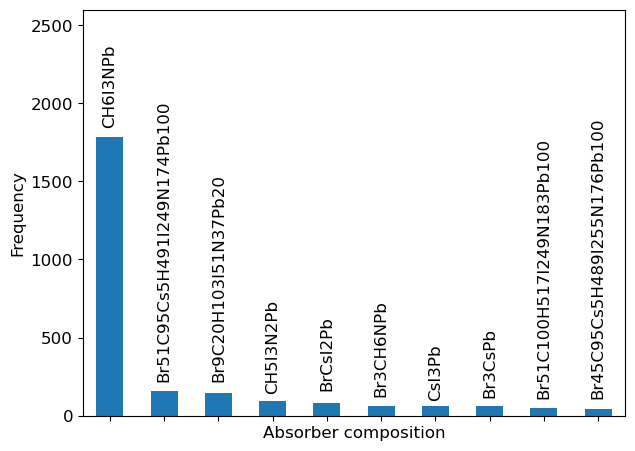

In [23]:
import matplotlib.pyplot as plt

font = {'family' : '',
    'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)

category_counts = df_all_identified['reduced_formulas'].value_counts().head(10)
# Plot the bar chart
ax = category_counts.plot(kind='bar', figsize=(7, 7))

# Adjust the position and rotation of x-axis labels
plt.xticks(rotation=90, va='top', ha='center')

stupid_help_counter = 0
for tick in ax.get_xticklabels():
    stupid_help_counter += 1
    if stupid_help_counter == 1:
        tick.set_y(0.94)
    elif stupid_help_counter == 2:
        tick.set_y(0.80)
    elif stupid_help_counter == 3:
        tick.set_y(0.62)
    elif stupid_help_counter == 4:
        tick.set_y(0.31)
    elif stupid_help_counter == 5:
        tick.set_y(0.27)
    elif stupid_help_counter == 6:
        tick.set_y(0.31)
    elif stupid_help_counter == 7:
        tick.set_y(0.2)
    elif stupid_help_counter == 8:
        tick.set_y(0.24)
    elif stupid_help_counter == 9:
        tick.set_y(0.71)
    elif stupid_help_counter == 10:
        tick.set_y(0.76)

# Optionally, you can add more space for the labels if needed
plt.subplots_adjust(bottom=0.3)
plt.xlabel('Absorber composition')
plt.ylabel('Frequency')

plt.ylim(0,2600)

# Display the plot
plt.show()

5424
3390
2034
0.375


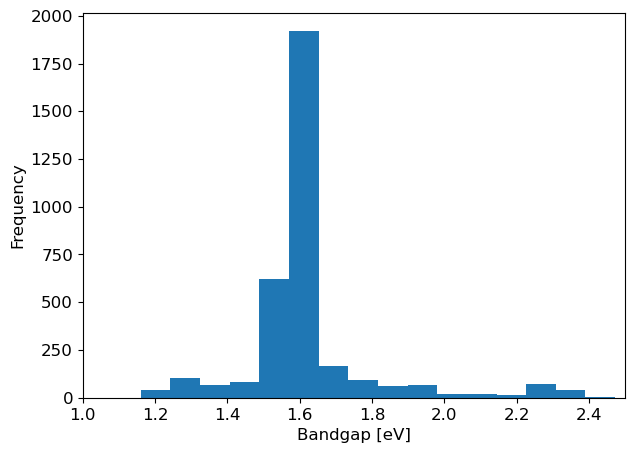

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter out the 0 values
print(len(df_all_identified))
filtered_df = df_all_identified[df_all_identified['bandgap'] != 0]
print(len(filtered_df))
print(len(df_all_identified)-len(filtered_df))
print(1-len(filtered_df)/len(df_all_identified))

# Plotting the histogram of filtered bandgap values
filtered_df['bandgap'].plot(kind='hist', bins=20, figsize=(7, 5))
plt.xlabel('Bandgap [eV]')
plt.ylabel('Frequency')
plt.xlim(1,2.5)
plt.show()

In [22]:
df_test = pd.read_csv('data_RO2/df_pce_prediction.csv')
df_test['pce'] = pd.to_numeric(df_test['pce'], errors='coerce')
df_test = df_test.dropna(subset=['pce'])
df_test['pce'].sort_values().tail(30)

27077    24.50
38898    24.66
42734    24.70
442      24.80
9100     24.82
9431     25.20
62       25.26
19106    25.40
6806     25.70
14395    25.90
24422    26.10
41816    26.25
319      26.30
13755    27.10
9024     28.94
32867    29.44
8350     29.60
30183    30.01
17187    30.30
21019    30.60
35524    31.40
2738     32.30
10554    33.00
7638     33.40
27369    34.80
26363    35.20
29119    35.20
15019    35.20
35989    35.90
38480    36.20
Name: pce, dtype: float64

# Check for most prevalent combination

In [14]:
row = df_all_identified[
    (df_all_identified['reduced_formulas'] == "CH6I3NPb") & 
    (df_all_identified['etl'].apply(str) == str(['TiO2-c', 'TiO2-mp'])) & 
    (df_all_identified['htl'].apply(str) == str(['Spiro-MeOTAD']))
]

row

,reduced_formulas,etl,htl,bandgap,device_stack,pce,etl_SMILES,htl_SMILES
4918,CH6I3NPb,"['TiO2-c', 'TiO2-mp']",['Spiro-MeOTAD'],0.000,"['SLG', 'FTO', 'TiO2-c', 'TiO2-mp', 'Perovskit...",11.954778,"['O=[Ti]=O', 'O=[Ti]=O']",['COC1=CC=C(C=C1)N(C2=CC=C(C=C2)OC)C3=CC4=C(C=...
4919,CH6I3NPb,"['TiO2-c', 'TiO2-mp']",['Spiro-MeOTAD'],1.300,"['SLG', 'FTO', 'TiO2-c', 'TiO2-mp', 'Perovskit...",12.270000,"['O=[Ti]=O', 'O=[Ti]=O']",['COC1=CC=C(C=C1)N(C2=CC=C(C=C2)OC)C3=CC4=C(C=...
4920,CH6I3NPb,"['TiO2-c', 'TiO2-mp']",['Spiro-MeOTAD'],1.480,"['SLG', 'FTO', 'TiO2-c', 'TiO2-mp', 'Perovskit...",11.296250,"['O=[Ti]=O', 'O=[Ti]=O']",['COC1=CC=C(C=C1)N(C2=CC=C(C=C2)OC)C3=CC4=C(C=...
4921,CH6I3NPb,"['TiO2-c', 'TiO2-mp']",['Spiro-MeOTAD'],1.481,"['SLG', 'FTO', 'TiO2-c', 'TiO2-mp', 'Perovskit...",17.371667,"['O=[Ti]=O', 'O=[Ti]=O']",['COC1=CC=C(C=C1)N(C2=CC=C(C=C2)OC)C3=CC4=C(C=...
4922,CH6I3NPb,"['TiO2-c', 'TiO2-mp']",['Spiro-MeOTAD'],1.486,"['SLG', 'FTO', 'TiO2-c', 'TiO2-mp', 'Perovskit...",17.085000,"['O=[Ti]=O', 'O=[Ti]=O']",['COC1=CC=C(C=C1)N(C2=CC=C(C=C2)OC)C3=CC4=C(C=...
4923,CH6I3NPb,"['TiO2-c', 'TiO2-mp']",['Spiro-MeOTAD'],1.500,"['SLG', 'FTO', 'TiO2-c', 'TiO2-mp', 'Perovskit...",11.098288,"['O=[Ti]=O', 'O=[Ti]=O']",['COC1=CC=C(C=C1)N(C2=CC=C(C=C2)OC)C3=CC4=C(C=...
4924,CH6I3NPb,"['TiO2-c', 'TiO2-mp']",['Spiro-MeOTAD'],1.510,"['SLG', 'FTO', 'TiO2-c', 'TiO2-mp', 'Perovskit...",11.503750,"['O=[Ti]=O', 'O=[Ti]=O']",['COC1=CC=C(C=C1)N(C2=CC=C(C=C2)OC)C3=CC4=C(C=...
4925,CH6I3NPb,"['TiO2-c', 'TiO2-mp']",['Spiro-MeOTAD'],1.520,"['SLG', 'FTO', 'TiO2-c', 'TiO2-mp', 'Perovskit...",12.673333,"['O=[Ti]=O', 'O=[Ti]=O']",['COC1=CC=C(C=C1)N(C2=CC=C(C=C2)OC)C3=CC4=C(C=...
4926,CH6I3NPb,"['TiO2-c', 'TiO2-mp']",['Spiro-MeOTAD'],1.530,"['SLG', 'FTO', 'TiO2-c', 'TiO2-mp', 'Perovskit...",10.960250,"['O=[Ti]=O', 'O=[Ti]=O']",['COC1=CC=C(C=C1)N(C2=CC=C(C=C2)OC)C3=CC4=C(C=...
4927,CH6I3NPb,"['TiO2-c', 'TiO2-mp']",['Spiro-MeOTAD'],1.540,"['SLG', 'FTO', 'TiO2-c', 'TiO2-mp', 'Perovskit...",10.976667,"['O=[Ti]=O', 'O=[Ti]=O']",['COC1=CC=C(C=C1)N(C2=CC=C(C=C2)OC)C3=CC4=C(C=...


# Platform info

In [ ]:
import platform,socket,re,uuid,json,psutil,logging

def getSystemInfo():
    try:
        info={}
        info['platform']=platform.system()
        info['platform-release']=platform.release()
        info['platform-version']=platform.version()
        info['architecture']=platform.machine()
        info['hostname']=socket.gethostname()
        info['ip-address']=socket.gethostbyname(socket.gethostname())
        info['mac-address']=':'.join(re.findall('..', '%012x' % uuid.getnode()))
        info['processor']=platform.processor()
        info['ram']=str(round(psutil.virtual_memory().total / (1024.0 **3)))+" GB"
        return json.dumps(info)
    except Exception as e:
        logging.exception(e)

json.loads(getSystemInfo())